# Standard segmentation/measurement
Typical steps are import, project (sum or max or combo), backsub.
Then blur, thresfrac (max, percentile, avg), filter objects (area/circ), dilate (border)
Then measure subtracted and shapes and output table.

In [1]:
# This notebook follows a standard segmentation workflow
import numpy as np
import tifffile
#import napari
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as ndi
from napari_ip_workflow import ipfunctions as ipf

In [2]:
#first load the images, here we have individually saved channels
fnames=['003003-1-001001001.tif','003003-1-001001002.tif','003003-1-001001003.tif']
img=np.array([tifffile.imread(fnames[i]) for i in range(len(fnames))])

In [3]:
#find the best background position
minx,miny,backavg,_,_=ipf.findBackground(img,3,40,200,30)
print('background pos:'+str([minx,miny]))
print('background measurements:'+str(backavg))

sm chan mins: [95, 94, 112]
flat min index:153000
background pos:[200, 425]
background measurements:[143.49627791563276, 130.68876285005317, 149.26409074796172]


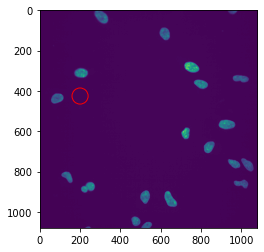

In [4]:
#show the background position for reference
plt.imshow(img[0])
plt.gca().add_patch(patches.Circle((minx,miny),40,ec='red',fc='none'))
plt.show()

In [5]:
backsub=[img[i]-backavg[i] for i in range(len(img))]

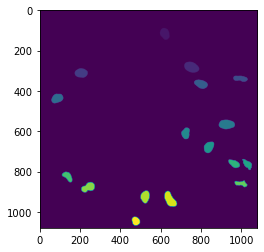

In [7]:
#now segment the nuclei
seglabels=ipf.findNuclei(backsub[0],smstd=3,threshfrac=0.25,threshstat='Max',minarea=10,maxarea=1e+6)
plt.imshow(seglabels)

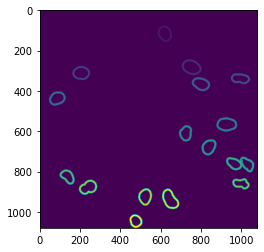

In [8]:
#now find find the cytoplasmic labels
cytolabels=ipf.findCirc(backsub[0],smstd=3,threshfrac=0.25,threshstat='Max',minarea=10,maxarea=1e+6,circrad=10)
plt.imshow(cytolabels)

In [10]:
#measure the nuclei in the second channel
measdf=ipf.getMeasurement(img[1],seglabels,[miny,minx],statfunc='Avg',getareas=True)
measdf.head()

,stat,area
0,1487.944936,2122.0
1,1436.852363,3002.0
2,1178.360796,2320.0
3,2640.108782,1572.0
4,2108.461996,2146.0


In [11]:
cytodf=ipf.getMeasurement(img[1],cytolabels,[miny,minx],statfunc='Avg',getareas=True)
cytodf.head()

,stat,area
0,26.637452,2070.0
1,22.852866,2407.0
2,8.155578,2150.0
3,26.014598,2093.0
4,22.020968,2140.0


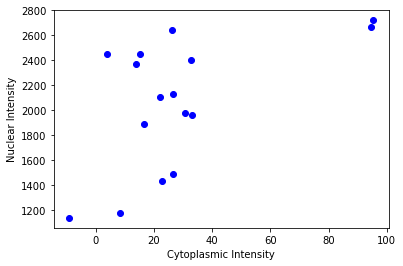

In [14]:
plt.plot(cytodf['stat'],measdf['stat'],'bo')
plt.xlabel('Cytoplasmic Intensity')
plt.ylabel('Nuclear Intensity')
plt.show()